# Machine Learning Mini-Project 2
### By : Tanasorn Chindasook and Prateek Kumar Choudhary
#### Date : 18.04.2019
A single run end to end implementation exists in the last cell of this notebook which can be run independenly of everything else.

In [12]:
# Import the libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from random import shuffle
import statistics 


# Set the folder location where the data file is location
file_path = 'DigitsBasicRoutines/'

# Read text file to a data frame
df = pd.read_csv(file_path+'mfeat-pix.txt',sep = " ", header = None)
# Drop empty columns
df = df.dropna(axis=1, how='all').values

In [13]:
# Code to create the teacher vectors. 
# Arguments: Number of classes and Number of observations per class
def create_teacher_vectors(classes, observations):
    teacher_vectors = []
    for i in range(classes):
        for j in range(observations):
            arr = np.zeros((classes,), dtype=int)
            arr[i] = 1
            teacher_vectors.append(arr)
    return teacher_vectors

In [14]:
# Function to generate principal components for the given data.
# Arguments: Dataset and Number of principal components
def PCA(df,pcs):
    # Centre datapoints first
    centred_data = df.T - df.T.mean()  # Transpose and Substract mean
    
    # Create the covariance matrix for our centred datapoints
    covariance_matrix = np.cov(centred_data)
    
    # Eigenvalue / eigen vector decomposition of covariance matrix
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    
    # Create tuples / pairs of corresponding eignevectors with its eigenvalues 
    eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)  # Sort by the eigen values
    
    # Only return the selected number of principal components
    variances = []
    principal_components = []
    for i in range(pcs):
        variances.append(eigen_pairs[i][0])
        principal_components.append(eigen_pairs[i][1])
    
    # Projecting PC into feature vectors, first make list into array type
    W = np.array(principal_components)
    projection_coordinates = W.T
    
    # Project the datapoints onto the PCS, transformed will have the shape d * 1000 where each column is a pattern
    features_pca = W.dot(df.T)
    
    return variances, principal_components, projection_coordinates, features_pca

In [15]:
# Function to generate softmax
# Arguments : Vector and Alpha parameter value
def softmax(v,a):
    return np.exp(a*v) / np.sum(np.exp(a*v), axis=1)

In [16]:
# Create a class to run the regression
class RidgeRigression:
    Wopt = np.zeros(1)  # Solution matrix
    
    # Method to fit the mode, i.e. Generate the solution matrix.
    def fitModel(self, features, output, alpha):
        '''Method to generate the solution matrix based on the provided training features
        and labels.
        Dimentions-
        n-Number of rows, m-Number of features, k-Number of output classes.
        Arguments-
        x_train : nxm Features with rows as individual observations.
        y_train : nxk Outcome matrix.
        Output-
        Sets the Wopt variable of the class to a (m+1)xk solution matrix.
        '''
        X = np.array(features)
        y = np.array(output)
        # Add the bias vector
        ones = np.ones(len(X))
        X = np.column_stack((ones, X))
        # Compute Wopt
        ridge_penalty = (alpha**2)*np.identity(len(X.T))
        pseudo_inverse = np.linalg.pinv(np.dot(X.T, X)+ridge_penalty)
        self.Wopt = np.matrix(np.dot(np.dot(pseudo_inverse, X.T), y),dtype = 'float')
     
    # Method to predict the outcome based on the solution matrix.
    def pred(self, features, alpha = 1):
        '''Method to generate predictions based on the fitted Wopt.
        Dimentions-
        n-Number of rows, m-Number of features, k-Number of output classes.
        Arguments-
        x_test : nxm Features with rows as individual observations.
        Output-
        Returns the array of predicted target k-dimensional vectors Z
        '''
        if(len(self.Wopt)==0):
            print('Please fit the model before running predict.')
            return
        return softmax((np.dot(features, self.Wopt[1:, ]) + self.Wopt[0, ]),alpha)

In [17]:
# Function to return image intensity values
# Arguments : image vector of length 240
def imgIntensities(imgVec):
    shape = (16, 15)
    imat = imgVec.reshape(shape)
    totalIntensity = imat.sum()
    topIntensity = imat[:8, :].sum()
    bottomIntensity = imat[8:, :].sum()
    leftIntensity = imat[:, :7].sum()
    rightIntensity = imat[:, 7:].sum()
    return(totalIntensity, topIntensity, bottomIntensity,
           leftIntensity, rightIntensity)


# Function to assign each data point to a random cluster
# Arguments :
# df : the two dimnestional data array of image vectors
# k : number of clusters to which the data should be assigned
def random_assign_class(df, k):
    # Ensure that all classes are initialised at least once
    x = [x for x in range(k)]
    shuffle(x)
    # Fill in the other points that havent been initialised randomly
    missing_index = len(df) - len(x)
    missing_values = np.random.randint(0, k, missing_index)
    # join the two random initialisations together
    final_initialisation = x + missing_values.tolist()
    groups = np.zeros((len(final_initialisation), 1))
    for indx, item in enumerate(final_initialisation):
        groups[indx] = item
    data = np.append(df, groups, axis=1)
    return data


# Function to run K-Means clustering, takes two arguments
# data : ndarray of data points that need to be clustered
# clusterSize : number of clusters
def kmeans(data, clusterSize):
    numData = len(data)         # Number of data points
    dimSize = len(data[0])      # Dimension of each data point
    # Assign each point to a cluster randomly
    data = random_assign_class(data, clusterSize)

    # Keep running the kmeans algorithm while the classes keep changing
    classChange = True
    while classChange == True:
        # Store the old class values for all the image vectors
        oldClasses = data[:, -1].copy()
        # Calculate the centroid for each group and store it in a numpy array
        # the centroid is just an average of all the points in the group
        centroid = np.zeros((clusterSize, dimSize))
        for i in range(len(centroid)):
            if (len(data[data[:, -1] == i]))!= 0 :
                centroid[i] = np.sum(data[data[:, -1] == i][:, :-1], axis=0)/len(data[data[:, -1] == i])
            else :
                np.delete(centroid,centroid[i],axis = 0)

        # Calculate the distance of each point from all the centroids
        distances = np.zeros((numData, clusterSize))
        for i in range(len(distances)):
            for j in range(len(distances[i])):
                distances[i, j] = np.linalg.norm(data[i, :-1]-centroid[j])
        # Re-assign the groups based on closest centroid
        for i in range(len(distances)):
            data[i, -1] = np.argmin(distances[i])
        # Store the new class values for the image vector
        newClasses = data[:, -1].copy()

        # Compare if the old and new classes are the same
        if sum(newClasses != oldClasses) == 0:
            classChange = False

    return centroid

In [18]:
# Function to generate the Mean Squared Error value 
# Arguments : Vector of Predicted values and Vector of Actual values
def MSE(pred,actual):
    v = pred-actual
    squared_error = []
    for i in range(len(v)):
        err = (np.linalg.norm(v[i]))**2
        squared_error.append(err)
    return statistics.mean(squared_error)


# Function to generate the Misclassification Error value 
# Arguments : Vector of Predicted values and Vector of Actual values
def misclassification_rate(pred,actual):
    return 1-((sum(np.array([np.argmax(a) for a in pred])==np.array([np.argmax(a) for a in actual]))).astype("float")/len(actual))


# Function that merges train test set together for CV dataset
# Arguments:
# Train_X : Array of training feature vectors
# Train_Y : Array of training output vectors
# Test_X : Array of test feature vectors
# Test_Y : Array of test output vectors
def create_full_dataset(train_X,train_y,test_X,test_y):
    data = np.concatenate((train_X,test_X))
    labels = np.concatenate((train_y,test_y)).tolist()

    df_full = pd.DataFrame(data)
    df_full['label'] = labels
    dataset = df_full.values
    
    return dataset


# Function to cross validate a model using k-fold cross validation and generate CV error rates
# Arguments :
# Dataset: The complete dataset which will be used for cross validation
# k : Number of folds to be used for cross validation
# model : Ridge regression class object that will be used for cross validation
# alpha : Parameter value for the ridge
def kfold_cv(dataset,k,model,alpha):
    size = int(len(dataset)/k)
    #shuffle array
    np.random.shuffle(dataset)
    
    cv_miss = []
    cv_mse = []
    for i in range(k):
    
        #create train and test indices
        test_indices = range(i*size,size+(i*size))
        train_indices = range(0,len(dataset))
        #remove the test indices from the train set
        train_indices = [x for x in train_indices if x not in test_indices]
    
        #split train test sets
        test_arr = dataset[test_indices]
        train_arr = dataset[train_indices]
    
        #split the features and the respons
        tr_x = train_arr[:,0:len(dataset.T)-1].astype("int")
        te_x = test_arr[:,0:len(dataset.T)-1].astype("int")
        tr_y = train_arr[:,-1].tolist()
        te_y = test_arr[:,-1].tolist()
    
        #fit model
        clf = model
        clf.fitModel(tr_x,tr_y,alpha)
        ypred = clf.pred(te_x)
        
        #compute misclassification rate
        cv_miss.append(1-((sum(np.array([np.argmax(a) for a in ypred])==np.array([np.argmax(a) for a in te_y]))).astype("float")/size))
        
        #compute MSE
        cv_mse.append(MSE(ypred,te_y))
        
    return statistics.mean(cv_miss), statistics.mean(cv_mse)


# Function to generate training, testing and cross validation scores
# Arguments:
# Train_x : Features used for training the model
# Train_pred : Predicted outcome values for training data
# Train_actual : Actual outcome values in the training data
# Test_x : Features used for testing the model
# Test_pred : Predicted outcome values for training data
# Test_actual : Actual outcome values in the training data
# Folds : Number of folds for k-fold C.V.
# Alpha : Ridge parameter to be passed to Cross validation method
def validation_scheme(train_x,train_pred,train_actual,test_x,test_pred,test_actual,folds,alpha):
    #training misclassification
    train_miss = misclassification_rate(train_pred,train_actual)
    #test misclassification
    test_miss = misclassification_rate(test_pred,test_actual)
    
    #train MSE
    train_mse = MSE(train_pred,train_actual)
    #test MSE
    test_mse = MSE(test_pred,test_actual)
    
    #CV
    cv_miss, cv_mse = kfold_cv(create_full_dataset(train_x,train_y,test_x,test_y),folds,RidgeRigression(),alpha)
    
    return train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse

Now that we have the framework ready we start testing our models with different feature sets.

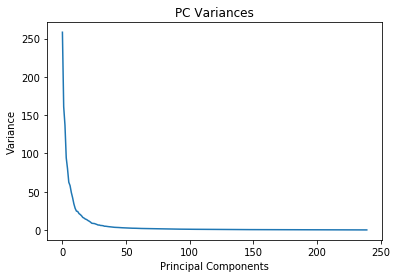

In [19]:
# Split the data into train and test sets
train_X = np.copy(df[:100, :])  # first 100 rows of the data(half of 0s)
test_X = np.copy(df[100:200, :])  # 2nd 100 rows of the data(other half of 0s)
train_y = create_teacher_vectors(10,100)  # Create teacher(result) vector for 1000 rows
test_y = create_teacher_vectors(10,100)  # Create teacher(result) vector for 1000 rows
for i in range(9):
    train_X = np.append(train_X, df[((i+1)*200):100+((i+1)*200), :], axis=0)
    test_X = np.append(test_X, df[100+((i+1)*200):200+((i+1)*200), :], axis=0)
    
#Perform PCA on train data and plot the variances (240 PCs for visualisation) 
train_pc_var, train_pcs,train_coords ,train_features_pca = PCA(train_X,len(train_X.T))
#test_pc_var, test_pcs, test_features_pca = PCA(test_X, len(test_X.T))

#Plot the variances covered by the principal components
x = range(0,len(train_pc_var))
y = train_pc_var
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Variance')
plt.title('PC Variances')
plt.show()

In [20]:
# Fit a base model without any feature engineering
clf = RidgeRigression()  # Initialize a classifier
# Fit on the data directly and check result
clf.fitModel(train_X,train_y,0)
ypred_train = clf.pred(train_X)
ypred_test = clf.pred(test_X)

base_train_miss,base_test_miss,base_train_mse,base_test_mse, base_cv_miss, base_cv_mse = validation_scheme(train_X,ypred_train,train_y,test_X,ypred_test,test_y,5,0)

print("Base Model")
print("Train MISS: " + str(base_train_miss))
print("Test MISS: " + str(base_test_miss))
print("Train MSE: " + str(base_train_mse))
print("Test MSE: " + str(base_test_mse))
print("CV MISS: " + str(base_cv_miss))
print("CV MSE: " + str(base_cv_mse))

Base Model
Train MISS: 0.019000000000000017
Test MISS: 0.08299999999999996
Train MSE: 0.7254636223153181
Test MSE: 0.7451792225739559
CV MISS: 0.06799999999999999
CV MSE: 0.7464730093894236


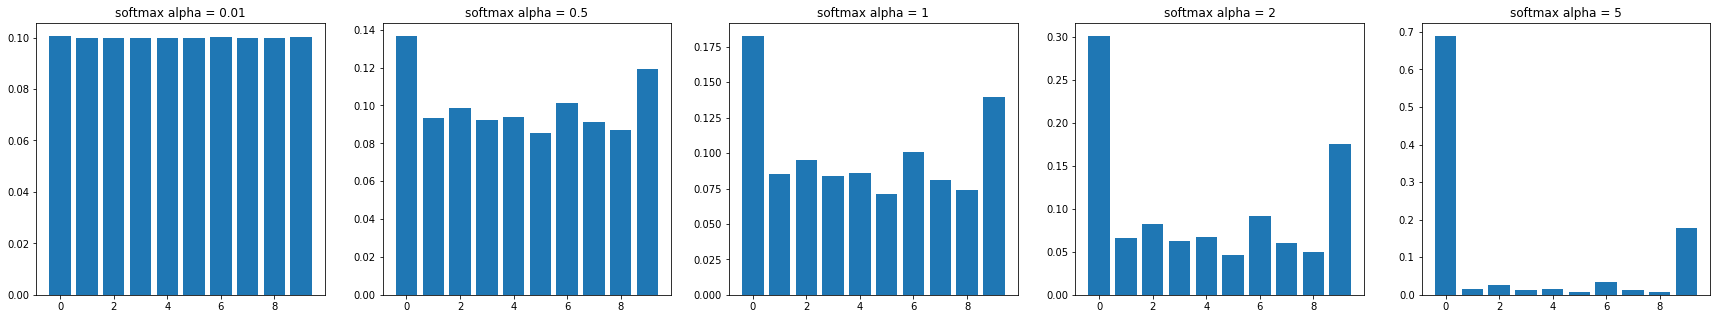

In [23]:
#PLot softmax graphs
plt.figure(figsize=(30,5))

softmax_alphas = [0.01,0.5,1,2,5]
maxRw = 1
maxCl = 5
cnt = 0

for alpha in softmax_alphas:
    ypred_test = clf.pred(test_X,alpha)
    x=range(0,10)
    hvect = ypred_test[0].tolist()[0]
    cnt=cnt+1
    ax = plt.subplot(1, maxCl, cnt)
    ax.bar(x,hvect)
    ax.set_title('softmax alpha = ' + str(alpha))

In [24]:
#Compare the base model to the base model + our hand designed features
# With distance and image intensities
featVec = []
for indx, itm in enumerate(train_X):
    imgIntVec = imgIntensities(itm)
    featVec = np.append(featVec, imgIntVec)
featVec = featVec.reshape(1000, 5)
featFinalVec = np.append(train_X,featVec, axis=1)
featTestVec = []
for indx, itm in enumerate(test_X):
    imgIntVec = imgIntensities(itm)
    featTestVec = np.append(featTestVec, imgIntVec)
featTestVec = featTestVec.reshape(1000, 5)
featFinalTestVec = np.append(test_X,featTestVec, axis=1)

clf1 = RidgeRigression()  # Initialize a classifier
clf1.fitModel(featFinalVec, train_y, 0)
ypred_train = clf1.pred(featFinalVec)
ypred_test = clf1.pred(featFinalTestVec)

base_f_train_miss,base_f_test_miss,base_f_train_mse,base_f_test_mse, base_f_cv_miss, base_f_cv_mse = validation_scheme(featFinalVec,ypred_train,train_y,featFinalTestVec,ypred_test,test_y,5,0)

print("Base Model + Hand Designed Features")
print("Train MISS: " + str(base_f_train_miss))
print("Test MISS: " + str(base_f_test_miss))
print("Train MSE: " + str(base_f_train_mse))
print("Test MSE: " + str(base_f_test_mse))
print("CV MISS: " + str(base_f_cv_miss))
print("CV MSE: " + str(base_f_cv_mse))

Base Model + Hand Designed Features
Train MISS: 0.019000000000000017
Test MISS: 0.08299999999999996
Train MSE: 0.7254636223153529
Test MSE: 0.7451792225730405
CV MISS: 0.06749999999999998
CV MSE: 0.7461229375593184


In [25]:
#Optimising the number of PCs to use
cvmiss_pca, cvmse_pca, trainmse_pca, testmse_pca, trainmiss_pca, testmiss_pca = [],[],[],[],[],[]
pca_results = [cvmiss_pca, cvmse_pca, trainmse_pca, testmse_pca, trainmiss_pca, testmiss_pca]
alphas = [0,0.0001,0.001,0.01,0.1,0.5,1,5,10,100,1000,10000]

for i in range(1,101):
    train_pc_var, train_pcs, train_coord, train_features_pca = PCA(train_X,i)

    #project test data into the new coordinates
    test_features_pca = train_coord.T.dot(test_X.T) 
    
    #training / testing model fit and predictions
    alpha_cvmiss,alpha_cvmse,alpha_trainmiss,alpha_testmiss,alpha_trainmse,alpha_testmse = [],[],[],[],[],[]
    alpha_results = [alpha_cvmiss,alpha_cvmse,alpha_trainmiss,alpha_testmiss,alpha_trainmse,alpha_testmse] 
    for a in alphas:
        clf.fitModel(train_features_pca.T, train_y, a)
        ypred_train = clf.pred(np.array(train_features_pca).T)
        ypred_test = clf.pred(np.array(test_features_pca).T)

        train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(train_features_pca.T,ypred_train,train_y,test_features_pca.T,ypred_test,test_y,5,a)
    
        alpha_cvmiss.append(cv_miss)
        alpha_cvmse.append(cv_mse)
        alpha_trainmiss.append(train_miss)
        alpha_testmiss.append(test_miss)
        alpha_trainmse.append(train_mse)
        alpha_testmse.append(test_mse)
    for result in pca_results:
        result.append(alpha_results[pca_results.index(result)])

In [26]:
def plot_validation_errors(x,y,x_type,y_type,title):
    errors = np.array(x).T
    x=range(1,len(errors.T)+1)
    ax1 = plt.plot()
    for i in range(len(errors)):
        plt.plot(x,errors[i],label = str(y[i]))
    plt.legend(loc='upper right')
    plt.xlabel(x_type)
    plt.ylabel(y_type)
    plt.title(title)
    #plt.xticks([x*10 for x in range(8)],[x*10+20 for x in range(8)])
    plt.yscale('log')
    plt.show()


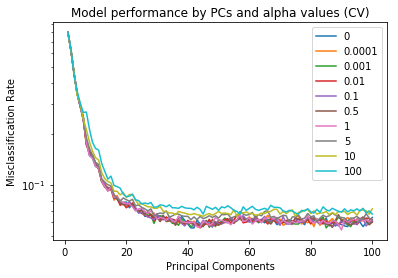

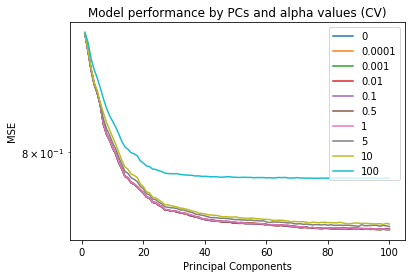

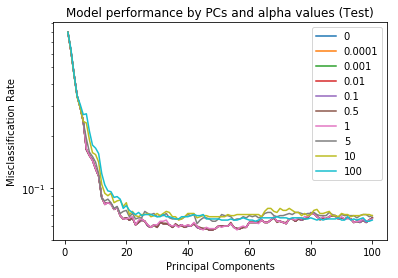

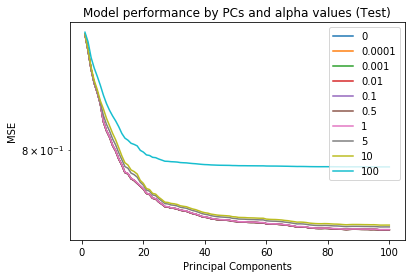

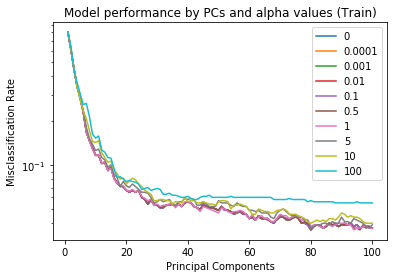

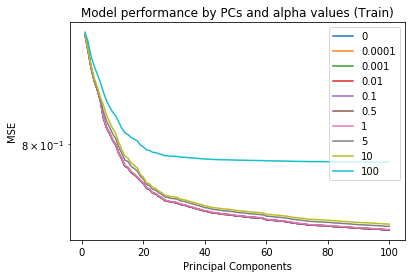

In [27]:
plot_validation_errors(np.array(cvmiss_pca)[:,:-2],alphas,"Principal Components","Misclassification Rate","Model performance by PCs and alpha values (CV)")
plot_validation_errors(np.array(cvmse_pca)[:,:-2],alphas,"Principal Components","MSE","Model performance by PCs and alpha values (CV)")
plot_validation_errors(np.array(testmse_pca)[:,:-2],alphas,"Principal Components","Misclassification Rate","Model performance by PCs and alpha values (Test)")
plot_validation_errors(np.array(testmiss_pca)[:,:-2],alphas,"Principal Components","MSE","Model performance by PCs and alpha values (Test)")
plot_validation_errors(np.array(trainmse_pca)[:,:-2],alphas,"Principal Components","Misclassification Rate","Model performance by PCs and alpha values (Train)")
plot_validation_errors(np.array(trainmiss_pca)[:,:-2],alphas,"Principal Components","MSE","Model performance by PCs and alpha values (Train)")

In [28]:
#print out the optimal PC for each alpha and its corresponding MISS rate
df_pca = pd.DataFrame(columns = ["alpha","PCs"])
for a in range(len(alphas)):
    #print("alpha: " + str(alphas[a])+ ", K: " + str(np.argmin(results[a])+1) + ", MISS:" + str(results[a][np.argmin(results[a])]))
    df_pca = df_pca.append({"alpha":str(alphas[a]),"PCs":np.argmin(np.array(cvmiss_pca).T[a])+1,"cv_MISS":np.array(cvmiss_pca).T[a][np.argmin(np.array(cvmiss_pca).T[a])],"cv_MSE":np.array(cvmse_pca).T[a][np.argmin(np.array(cvmse_pca).T[a])],"test_MISS":np.array(testmse_pca).T[a][np.argmin(np.array(testmse_pca).T[a])],"test_MSE":np.array(testmiss_pca).T[a][np.argmin(np.array(testmiss_pca).T[a])],"train_MISS":np.array(trainmse_pca).T[a][np.argmin(np.array(trainmse_pca).T[a])],"train_MSE":np.array(trainmiss_pca).T[a][np.argmin(np.array(trainmiss_pca).T[a])]},ignore_index=True)
df_pca

,alpha,PCs,cv_MISS,cv_MSE,test_MISS,test_MSE,train_MISS,train_MSE
0,0,42,0.0555,0.749679,0.057,0.746394,0.036,0.740557
1,0.0001,44,0.0560,0.749595,0.057,0.746394,0.036,0.740557
2,0.001,85,0.0555,0.749454,0.057,0.746394,0.036,0.740557
3,0.01,44,0.0555,0.749619,0.057,0.746394,0.036,0.740557
4,0.1,48,0.0560,0.749688,0.057,0.746396,0.036,0.740560
5,0.5,87,0.0560,0.749878,0.057,0.746450,0.036,0.740627
6,1,90,0.0540,0.749723,0.057,0.746605,0.036,0.740819
7,5,73,0.0600,0.751579,0.062,0.748303,0.037,0.742922
8,10,56,0.0650,0.752958,0.065,0.749489,0.040,0.744430
9,100,100,0.0670,0.782591,0.064,0.788087,0.055,0.787241


In [31]:
#Set the Optimal PCs and its alpha
pca_opt = int(df_pca["PCs"][np.argmin(df_pca["cv_MISS"])])
pca_opt_alpha = df_pca["alpha"][np.argmin(df_pca["cv_MISS"])]
print(pca_opt)
print(pca_opt_alpha)

90
1


In [32]:
#we also want to plot the visualisation for the relationship between the different errors
pca_cv_miss = []
pca_cv_mse = []
pca_test_mse = []
pca_train_mse = []
pca_train_miss = []
pca_test_miss = []

for i in range(1,101):
    train_pc_var, train_pcs, train_coord, train_features_pca = PCA(train_X,i)

    #project test data into the new coordinates
    test_features_pca = train_coord.T.dot(test_X.T) 
    
    #training / testing model fit and predictions
    clf.fitModel(train_features_pca.T, train_y, 0)
    ypred_train = clf.pred(np.array(train_features_pca).T)
    ypred_test = clf.pred(np.array(test_features_pca).T)

    train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(train_features_pca.T,ypred_train,train_y,test_features_pca.T,ypred_test,test_y,5,0)
    
    pca_cv_miss.append(cv_miss)
    pca_cv_mse.append(cv_mse)
    pca_test_mse.append(test_mse)
    pca_train_mse.append(train_mse)
    pca_train_miss.append(train_miss)
    pca_test_miss.append(test_miss)

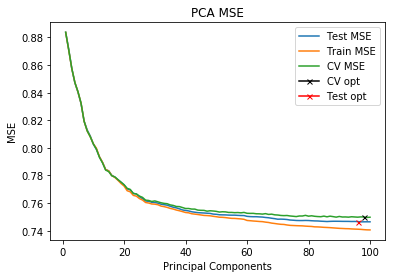

optimal PCs (CV): 98, MSE: 0.7496014915410627
optimal PCs (Test): 96, MSE: 0.746393972099929


In [33]:
#plot the train test MSE
x = range(1,101)
plt.plot(x,pca_test_mse, label = "Test MSE")
plt.plot(x,pca_train_mse, label = "Train MSE")
plt.plot(x,pca_cv_mse, label = "CV MSE")
plt.plot(np.argmin(pca_cv_mse), pca_cv_mse[np.argmin(pca_cv_mse)], marker='x', markersize=5, color="black", label = "CV opt")
plt.plot(np.argmin(pca_test_mse), pca_test_mse[np.argmin(pca_test_mse)], marker='x', markersize=5, color="red", label = "Test opt")
plt.legend(loc='upper right')
plt.xlabel('Principal Components')
plt.ylabel('MSE')
plt.title('PCA MSE')
plt.show()
print("optimal PCs (CV): " + str(np.argmin(pca_cv_mse)) + ", MSE: " +str(pca_cv_mse[np.argmin(pca_cv_mse)]))
print("optimal PCs (Test): " + str(np.argmin(pca_test_mse)) + ", MSE: " +str(pca_test_mse[np.argmin(pca_test_mse)]))

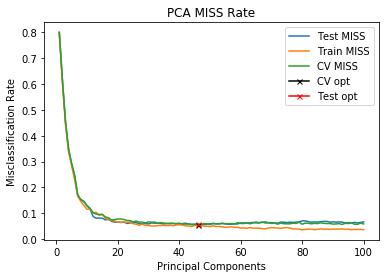

optimal PCs (CV): 47, MISS: 0.055499999999999994
optimal PCs (Test): 47, MISS: 0.05700000000000005


In [34]:
#plot the misclassification rate
x = range(1,101)
plt.plot(x,pca_test_miss, label = "Test MISS")
plt.plot(x,pca_train_miss, label = "Train MISS")
plt.plot(x,pca_cv_miss, label = "CV MISS")
plt.plot(np.argmin(pca_cv_miss), pca_cv_miss[np.argmin(pca_cv_miss)], marker='x', markersize=5, color="black", label = "CV opt")
plt.plot(np.argmin(pca_test_miss), pca_test_miss[np.argmin(pca_test_miss)], marker='x', markersize=5, color="red", label = "Test opt")
plt.legend(loc='upper right')
plt.xlabel('Principal Components')
plt.ylabel('Misclassification Rate')
plt.title('PCA MISS Rate')
plt.show()
print("optimal PCs (CV): " + str(np.argmin(pca_cv_miss)+1) + ", MISS: " +str(pca_cv_miss[np.argmin(pca_cv_miss)]))
print("optimal PCs (Test): " + str(np.argmin(pca_test_miss)+1) + ", MISS: " +str(pca_test_miss[np.argmin(pca_test_miss)]))


/home/prateek/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


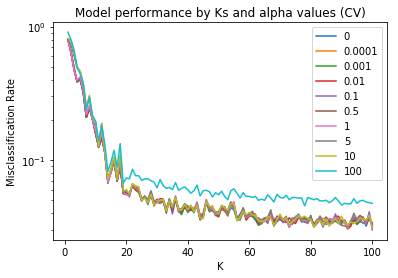

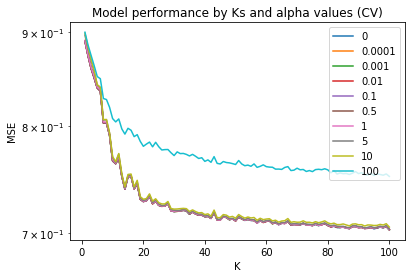

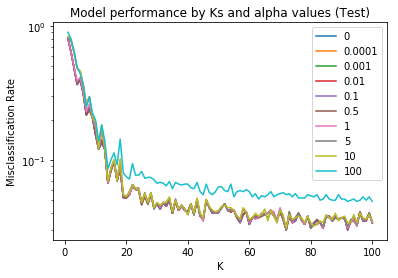

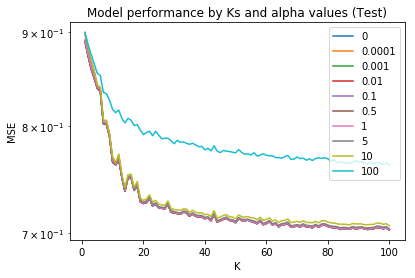

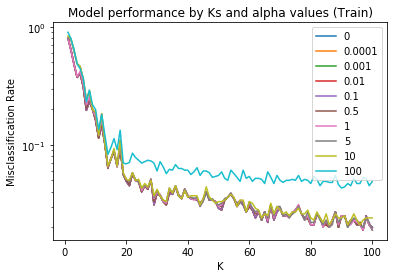

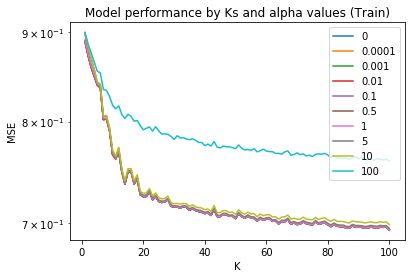

In [35]:
#Optimising the number of Ks to use along with the optimal alpha to use
cvmiss_km, cvmse_km, trainmse_km, testmse_km, trainmiss_km, testmiss_km = [],[],[],[],[],[]
km_results = [cvmiss_km, cvmse_km, trainmse_km, testmse_km, trainmiss_km, testmiss_km]
alphas = [0,0.0001,0.001,0.01,0.1,0.5,1,5,10,100,1000,10000]

for k in range(1,101):
    cbs = kmeans(train_X, k)

    # Distances from the codebook vectors
    distTrain = [np.linalg.norm(train_X-b,axis=1) for b in cbs]
    distTest = [np.linalg.norm(test_X-b,axis=1) for b in cbs]
    
    #initialise arrays to store predictions
    alpha_cvmiss,alpha_cvmse,alpha_trainmiss,alpha_testmiss,alpha_trainmse,alpha_testmse = [],[],[],[],[],[]
    alpha_results = [alpha_cvmiss,alpha_cvmse,alpha_trainmiss,alpha_testmiss,alpha_trainmse,alpha_testmse] 
    
    #training / testing model fit and predictions
    for a in alphas:
        clf2 = RidgeRigression()  # Initialize a classifier
        clf2.fitModel(np.array(distTrain).T, train_y, a)
        ypred_train = clf2.pred(np.array(distTrain).T)
        ypred_test = clf2.pred(np.array(distTest).T)
        train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(np.array(distTrain).T,ypred_train,train_y,np.array(distTest).T,ypred_test,test_y,5,a)
    
        alpha_cvmiss.append(cv_miss)
        alpha_cvmse.append(cv_mse)
        alpha_trainmiss.append(train_miss)
        alpha_testmiss.append(test_miss)
        alpha_trainmse.append(train_mse)
        alpha_testmse.append(test_mse)
        
    for result in km_results:
        result.append(alpha_results[km_results.index(result)])

plot_validation_errors(np.array(cvmiss_km)[:,:-2],alphas,"K","Misclassification Rate","Model performance by Ks and alpha values (CV)")
plot_validation_errors(np.array(cvmse_km)[:,:-2],alphas,"K","MSE","Model performance by Ks and alpha values (CV)")
plot_validation_errors(np.array(testmse_km)[:,:-2],alphas,"K","Misclassification Rate","Model performance by Ks and alpha values (Test)")
plot_validation_errors(np.array(testmiss_km)[:,:-2],alphas,"K","MSE","Model performance by Ks and alpha values (Test)")
plot_validation_errors(np.array(trainmse_km)[:,:-2],alphas,"K","Misclassification Rate","Model performance by Ks and alpha values (Train)")
plot_validation_errors(np.array(trainmiss_km)[:,:-2],alphas,"K","MSE","Model performance by Ks and alpha values (Train)")

In [36]:
#print out the optimal K for each alpha along with its error rate
df_km = pd.DataFrame(columns = ["alpha","K"])
for a in range(len(alphas)):
    df_km = df_km.append({"alpha":str(alphas[a]),"K":np.argmin(np.array(cvmiss_km).T[a])+1,"cv_MISS":np.array(cvmiss_km).T[a][np.argmin(np.array(cvmiss_km).T[a])],"cv_MSE":np.array(cvmse_km).T[a][np.argmin(np.array(cvmse_km).T[a])],"test_MISS":np.array(testmse_km).T[a][np.argmin(np.array(testmse_km).T[a])],"test_MSE":np.array(testmiss_km).T[a][np.argmin(np.array(testmiss_km).T[a])],"train_MISS":np.array(trainmse_km).T[a][np.argmin(np.array(trainmse_km).T[a])],"train_MSE":np.array(trainmiss_km).T[a][np.argmin(np.array(trainmiss_km).T[a])]},ignore_index=True)
df_km

,alpha,K,cv_MISS,cv_MSE,test_MISS,test_MSE,train_MISS,train_MSE
0,0,92,0.0310,0.703088,0.030,0.702585,0.019,0.693578
1,0.0001,92,0.0315,0.703161,0.030,0.702585,0.019,0.693578
2,0.001,84,0.0315,0.702972,0.030,0.702585,0.019,0.693578
3,0.01,92,0.0305,0.703157,0.030,0.702585,0.019,0.693578
4,0.1,100,0.0300,0.703319,0.030,0.702582,0.019,0.693588
5,0.5,73,0.0315,0.703268,0.030,0.702576,0.019,0.693660
6,1,92,0.0310,0.703161,0.030,0.702605,0.019,0.693723
7,5,91,0.0320,0.703664,0.030,0.703623,0.019,0.695105
8,10,81,0.0315,0.705493,0.031,0.706276,0.021,0.698521
9,100,78,0.0455,0.751609,0.049,0.761919,0.043,0.759294


/home/prateek/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


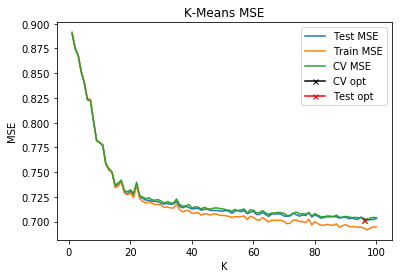

optimal K (CV): 96, MSE: 0.7013364477979391
optimal K (Test): 96, MSE: 0.7015514048420092


In [48]:
#Set the Optimal K and its alpha
k_opt = int(df_km["K"][np.argmin(df_km["cv_MISS"])])
k_opt_alpha = df_km["alpha"][np.argmin(df_km["cv_MISS"])]

# Check Kmeans for variations between the errors in relation to the number of k used, control case alpha = 0
km_cv_miss = []
km_cv_mse = []
km_test_mse = []
km_train_mse = []
km_train_miss = []
km_test_miss = []

for k in range(1,101):    
    cbs = kmeans(train_X, k)

    # Distances from the codebook vectors
    distTrain = [np.linalg.norm(train_X-b,axis=1) for b in cbs]
    distTest = [np.linalg.norm(test_X-b,axis=1) for b in cbs]

    clf2 = RidgeRigression()  # Initialize a classifier
    clf2.fitModel(np.array(distTrain).T, train_y, 1)
    ypred_train = clf2.pred(np.array(distTrain).T)
    ypred_test = clf2.pred(np.array(distTest).T)
    
    train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(np.array(distTrain).T,ypred_train,train_y,np.array(distTest).T,ypred_test,test_y,5,0)
    
    km_cv_miss.append(cv_miss)
    km_cv_mse.append(cv_mse)
    km_test_mse.append(test_mse)
    km_train_mse.append(train_mse)
    km_train_miss.append(train_miss)
    km_test_miss.append(test_miss)
    
#plot the train test MSE
x = range(1,101)
plt.plot(x,km_test_mse, label = "Test MSE")
plt.plot(x,km_train_mse, label = "Train MSE")
plt.plot(x,km_cv_mse, label = "CV MSE")
plt.plot(np.argmin(km_cv_mse), km_cv_mse[np.argmin(km_cv_mse)], marker='x', markersize=5, color="black", label = "CV opt")
plt.plot(np.argmin(km_test_mse), km_test_mse[np.argmin(km_test_mse)], marker='x', markersize=5, color="red", label = "Test opt")
plt.legend(loc='upper right')
plt.xlabel('K')
plt.ylabel('MSE')
plt.title('K-Means MSE')
plt.show()
print("optimal K (CV): " + str(np.argmin(km_cv_mse)) + ", MSE: " +str(km_cv_mse[np.argmin(km_cv_mse)]))
print("optimal K (Test): " + str(np.argmin(km_test_mse)) + ", MSE: " +str(km_test_mse[np.argmin(km_test_mse)]))

In [49]:
km_test_miss

[0.813,
 0.677,
 0.622,
 0.401,
 0.357,
 0.29600000000000004,
 0.28600000000000003,
 0.245,
 0.17200000000000004,
 0.17000000000000004,
 0.16900000000000004,
 0.118,
 0.09699999999999998,
 0.09799999999999998,
 0.06899999999999995,
 0.07199999999999995,
 0.07799999999999996,
 0.05800000000000005,
 0.05700000000000005,
 0.061000000000000054,
 0.05400000000000005,
 0.06899999999999995,
 0.049000000000000044,
 0.05500000000000005,
 0.04800000000000004,
 0.051000000000000045,
 0.04800000000000004,
 0.051000000000000045,
 0.04700000000000004,
 0.04800000000000004,
 0.04600000000000004,
 0.052000000000000046,
 0.039000000000000035,
 0.04400000000000004,
 0.051000000000000045,
 0.04700000000000004,
 0.052000000000000046,
 0.04400000000000004,
 0.04300000000000004,
 0.041000000000000036,
 0.04500000000000004,
 0.040000000000000036,
 0.04300000000000004,
 0.04200000000000004,
 0.04300000000000004,
 0.038000000000000034,
 0.04600000000000004,
 0.04300000000000004,
 0.04400000000000004,
 0.042000

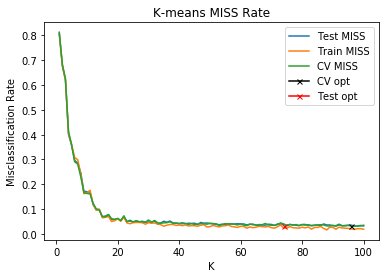

optimal K (CV): 96, MISS: 0.030500000000000017
optimal K (Test): 74, MISS: 0.03200000000000003


In [50]:
#plot the misclassification rate
x = range(1,101)
plt.plot(x,km_test_miss, label = "Test MISS")
plt.plot(x,km_train_miss, label = "Train MISS")
plt.plot(x,km_cv_miss, label = "CV MISS")
plt.plot(np.argmin(km_cv_miss), km_cv_miss[np.argmin(km_cv_miss)], marker='x', markersize=5, color="black", label = "CV opt")
plt.plot(np.argmin(km_test_miss), km_test_miss[np.argmin(km_test_miss)], marker='x', markersize=5, color="red", label = "Test opt")
plt.legend(loc='upper right')
plt.xlabel('K')
plt.ylabel('Misclassification Rate')
plt.title('K-means MISS Rate')
plt.show()
print("optimal K (CV): " + str((np.argmin(km_cv_miss))) + ", MISS: " +str(km_cv_miss[np.argmin(km_cv_miss)]))
print("optimal K (Test): " + str((np.argmin(km_test_miss))) + ", MISS: " +str(km_test_miss[np.argmin(km_test_miss)]))


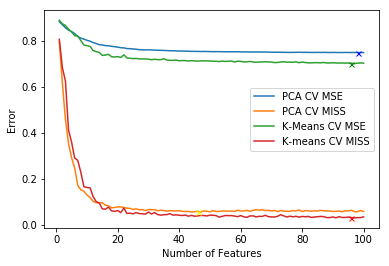

In [51]:
#plot PCA against kmeans
#plot the misclassification rate
x = range(1,101)
plt.plot(x,pca_cv_mse, label = "PCA CV MSE")
plt.plot(x,pca_cv_miss, label = "PCA CV MISS")
plt.plot(x,km_cv_mse, label = "K-Means CV MSE")
plt.plot(x,km_cv_miss, label = "K-means CV MISS")
plt.plot(np.argmin(km_cv_miss), km_cv_miss[np.argmin(km_cv_miss)], marker='x', markersize=5, color="red")
plt.plot(np.argmin(km_cv_mse), km_cv_mse[np.argmin(km_cv_mse)], marker='x', markersize=5, color="green")
plt.plot(np.argmin(pca_cv_miss), pca_cv_miss[np.argmin(km_cv_miss)], marker='x', markersize=5, color="yellow")
plt.plot(np.argmin(pca_cv_mse), pca_cv_mse[np.argmin(pca_cv_mse)], marker='x', markersize=5, color="blue")
plt.legend(loc='best')
plt.xlabel('Number of Features')
plt.ylabel('Error')
plt.title('')
plt.show()


In [52]:
#plot the ridge coeffs
def plot_ridge_coeffs(wopt,alphas):

    
    #create 10 subplots for the first 10 coeffs
    plt.figure(figsize=(40,10))
    ax1=plt.subplot(251)
    ax2=plt.subplot(252)
    ax3=plt.subplot(253)
    ax4=plt.subplot(254)
    ax5=plt.subplot(255)
    ax6=plt.subplot(256)
    ax7=plt.subplot(257)
    ax8=plt.subplot(258)
    ax9=plt.subplot(259)
    ax10=plt.subplot(2,5,10)

    ax_names = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]
    
    feature_1 = []
    feature_2 = []
    feature_3 = []
    feature_4 = []
    feature_5 = []
    feature_6 = []
    feature_7 = []
    feature_8 = []
    feature_9 = []
    feature_10 = []
    
    #get the first 10 coeffs 
    for i in range(0,10): 
        for j in range(len(alphas)):
            feature_1.append(wopt[j].T[i].T.tolist()[1])
            feature_2.append(wopt[j].T[i].T.tolist()[2])
            feature_3.append(wopt[j].T[i].T.tolist()[3])
            feature_4.append(wopt[j].T[i].T.tolist()[4])
            feature_5.append(wopt[j].T[i].T.tolist()[5])
            feature_6.append(wopt[j].T[i].T.tolist()[6])
            feature_7.append(wopt[j].T[i].T.tolist()[7])
            feature_8.append(wopt[j].T[i].T.tolist()[8])
            feature_9.append(wopt[j].T[i].T.tolist()[9])
            feature_10.append(wopt[j].T[i].T.tolist()[10])
            
    #plot the coeffs
    for ax in ax_names:
        ax.plot(alphas,feature_1[ax_names.index(ax)*len(alphas):(len(alphas)+(ax_names.index(ax)*len(alphas)))])
        ax.plot(alphas,feature_2[ax_names.index(ax)*len(alphas):(len(alphas)+(ax_names.index(ax)*len(alphas)))])
        ax.plot(alphas,feature_3[ax_names.index(ax)*len(alphas):len(alphas)+(ax_names.index(ax)*len(alphas))])
        ax.plot(alphas,feature_4[ax_names.index(ax)*len(alphas):len(alphas)+(ax_names.index(ax)*len(alphas))])
        ax.plot(alphas,feature_5[ax_names.index(ax)*len(alphas):len(alphas)+(ax_names.index(ax)*len(alphas))])
        ax.plot(alphas,feature_6[ax_names.index(ax)*len(alphas):len(alphas)+(ax_names.index(ax)*len(alphas))])
        ax.plot(alphas,feature_7[ax_names.index(ax)*len(alphas):len(alphas)+(ax_names.index(ax)*len(alphas))])
        ax.plot(alphas,feature_8[ax_names.index(ax)*len(alphas):len(alphas)+(ax_names.index(ax)*len(alphas))])
        ax.plot(alphas,feature_9[ax_names.index(ax)*len(alphas):len(alphas)+(ax_names.index(ax)*len(alphas))])
        ax.plot(alphas,feature_10[ax_names.index(ax)*len(alphas):len(alphas)+(ax_names.index(ax)*len(alphas))])
        #ax.xlabel("Alpha")
        #ax.ylabel("Weights")
        ax.set_title("Ridge Coefficients for Class " + str(ax_names.index(ax)))
        ax.set_xscale('log')
        plt.setp(ax, xlabel = "Alpha", ylabel = "Weights")


In [53]:
#Optimise the alpha parameter for the base model
base_a_train_miss,base_a_test_miss,base_a_train_mse,base_a_test_mse, base_a_cv_miss, base_a_cv_mse = [],[],[],[],[],[]
base_a_wopt = []
alphas = [0,0.0001,0.001,0.01,0.1,0.5,1,5,10,100,1000,10000]

#Append errors for different alphas
for a in alphas:
    clf_b = RidgeRigression()
    clf_b.fitModel(train_X, train_y, a)
    wopt = clf_b.Wopt
    ypred_train = clf_b.pred(train_X)
    ypred_test = clf_b.pred(test_X)


    train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(train_X,ypred_train,train_y,test_X,ypred_test,test_y,5,a)
    base_a_train_miss.append(train_miss)
    base_a_test_miss.append(test_miss)
    base_a_train_mse.append(train_mse)
    base_a_test_mse.append(test_mse)
    base_a_cv_miss.append(cv_miss)
    base_a_cv_mse.append(cv_mse)
    base_a_wopt.append(wopt)

print(alphas[np.argmin(base_a_cv_miss)])
print(alphas[np.argmin(base_a_cv_mse)])

100
0.001


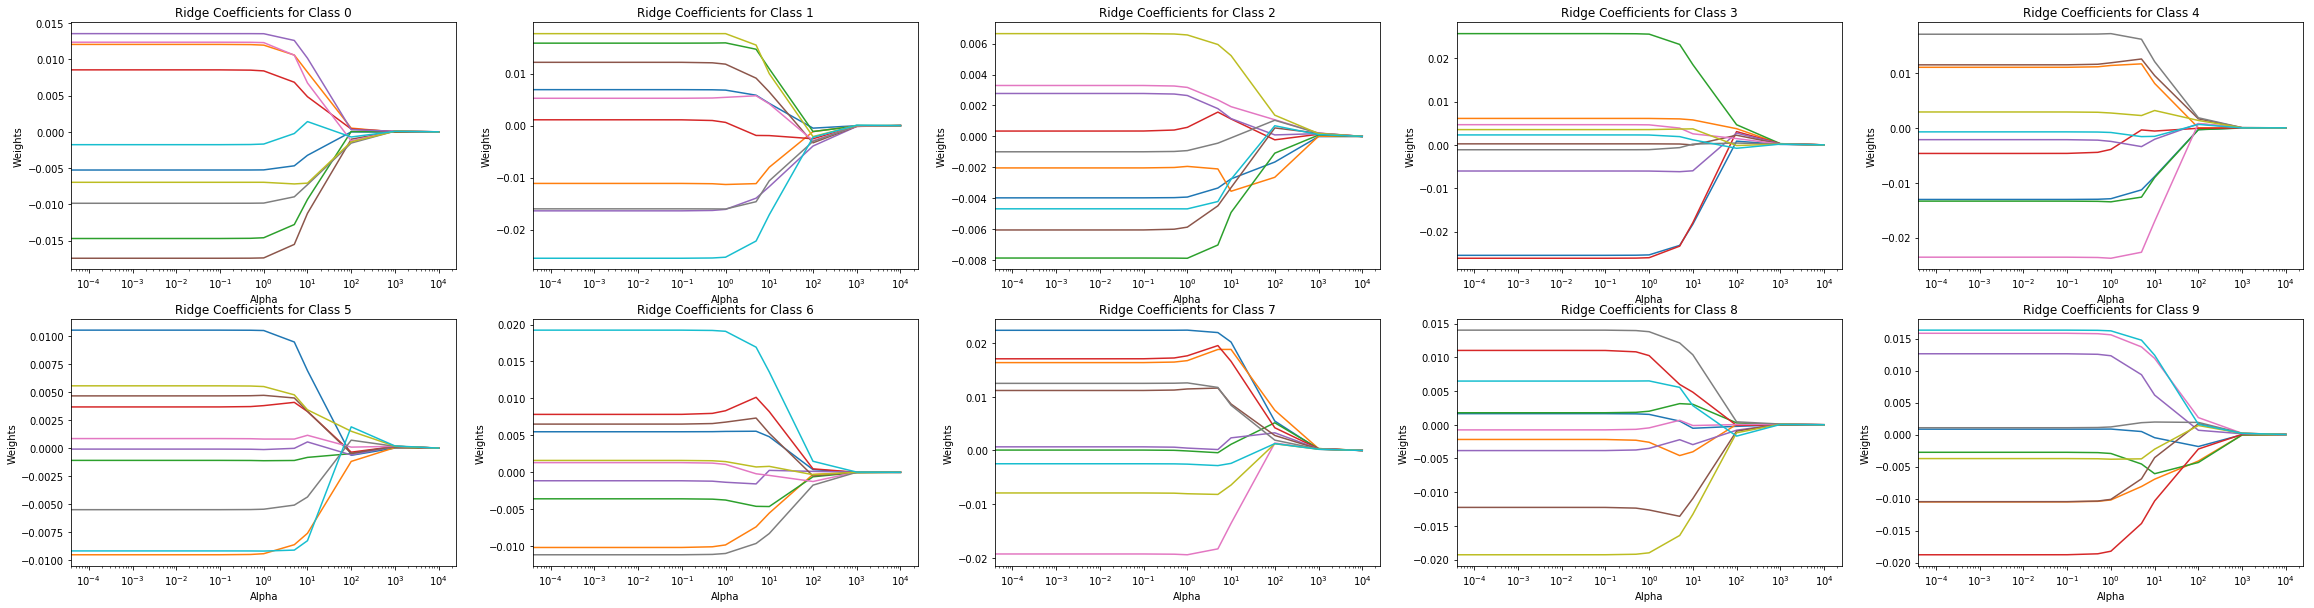

In [54]:
plot_ridge_coeffs(base_a_wopt,alphas)

In [55]:
##Optimising the Alpha Parameter for PCA
#So far we have done everything with alpha = 0 (Least squares regression), we will now optimise alpha
# With PCA (Optimal # of PCs)
train_pc_var, train_pcs, train_coord, train_features_pca = PCA(train_X,pca_opt)

#project test data into the new coordinates
test_features_pca = train_coord.T.dot(test_X.T)

pca_a_train_miss,pca_a_test_miss,pca_a_train_mse,pca_a_test_mse, pca_a_cv_miss, pca_a_cv_mse = [],[],[],[],[],[]
pca_a_wopt = []
alphas = [0,0.0001,0.001,0.01,0.1,0.5,1,5,10,100,1000,10000]

#Append errors for different alphas
for a in alphas:
    clf = RidgeRigression()
    clf.fitModel(train_features_pca.T, train_y, a)
    wopt = clf.Wopt
    ypred_train = clf.pred(np.array(train_features_pca).T)
    ypred_test = clf.pred(np.array(test_features_pca).T)


    train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(train_features_pca.T,ypred_train,train_y,test_features_pca.T,ypred_test,test_y,5,a)
    pca_a_train_miss.append(train_miss)
    pca_a_test_miss.append(test_miss)
    pca_a_train_mse.append(train_mse)
    pca_a_test_mse.append(test_mse)
    pca_a_cv_miss.append(cv_miss)
    pca_a_cv_mse.append(cv_mse)
    pca_a_wopt.append(wopt)

print(alphas[np.argmin(pca_a_cv_miss)])
print(alphas[np.argmin(pca_a_cv_mse)])

0.5
0.1


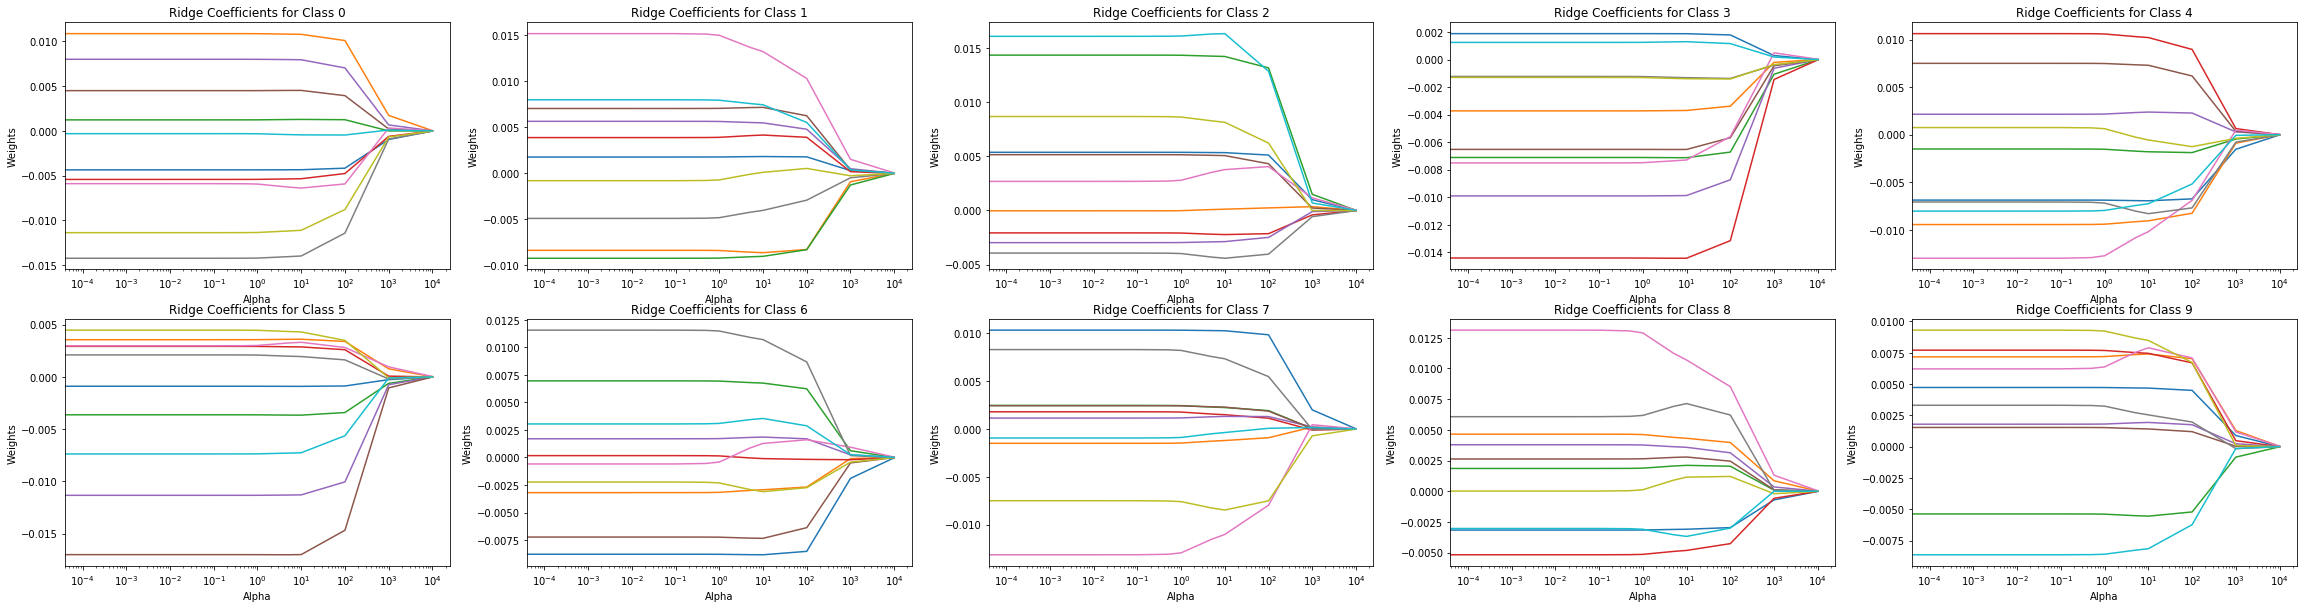

In [56]:
plot_ridge_coeffs(pca_a_wopt,alphas)

In [57]:
# Optimising alpha for the optimal k-means 
cbs = kmeans(train_X, k_opt)

# Distances from the codebook vectors
distTrain = [np.linalg.norm(train_X-b,axis=1) for b in cbs]
distTest = [np.linalg.norm(test_X-b,axis=1) for b in cbs]

km_a_train_miss,km_a_test_miss,km_a_train_mse,km_a_test_mse, km_a_cv_miss, km_a_cv_mse = [],[],[],[],[],[]
km_a_wopt = []

for a in alphas:
    
    clf2 = RidgeRigression()  # Initialize a classifier
    clf2.fitModel(np.array(distTrain).T, train_y, a)
    wopt = clf2.Wopt
    ypred_train = clf2.pred(np.array(distTrain).T)
    ypred_test = clf2.pred(np.array(distTest).T)
    
    train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(np.array(distTrain).T,ypred_train,train_y,np.array(distTest).T,ypred_test,test_y,5,a)
    
    km_a_train_miss.append(train_miss)
    km_a_test_miss.append(test_miss)
    km_a_train_mse.append(train_mse)
    km_a_test_mse.append(test_mse)
    km_a_cv_miss.append(cv_miss)
    km_a_cv_mse.append(cv_mse)
    km_a_wopt.append(wopt)

print(alphas[np.argmin(km_a_cv_miss)])
print(alphas[np.argmin(km_a_cv_mse)])

/home/prateek/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


0.5
0.5


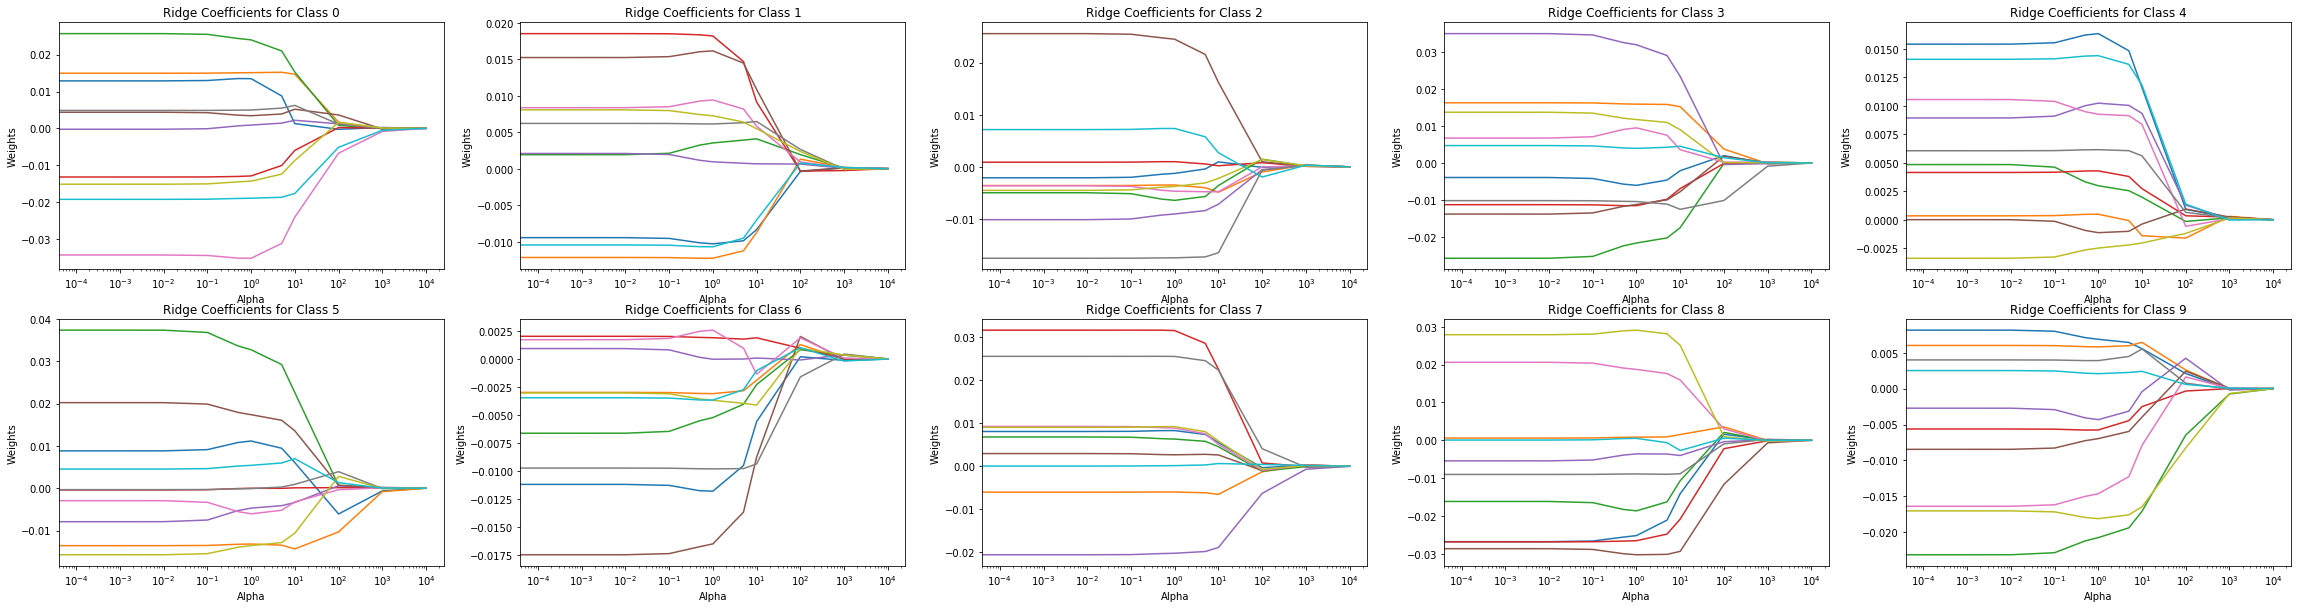

In [58]:
plot_ridge_coeffs(km_a_wopt,alphas)

In [59]:
# Optimising alpha for Combination 1: Optimal Kmeans and Hand designed features
#to keep it at 100 features:
if k_opt >= 96 :
    k_opt_f = k_opt - 5
else: 
    k_opt_f = k_opt
cbs = kmeans(train_X, k_opt_f)

# Distances from the codebook vectors
distTrain = [np.linalg.norm(train_X-b,axis=1) for b in cbs]
distTest = [np.linalg.norm(test_X-b,axis=1) for b in cbs]

featVec = []
for indx, itm in enumerate(train_X):
    imgIntVec = imgIntensities(itm)
    featVec = np.append(featVec, imgIntVec)
featVec = featVec.reshape(1000, 5)
featFinalVec = np.append(np.array(distTrain).T,featVec, axis=1)
featTestVec = []
for indx, itm in enumerate(test_X):
    imgIntVec = imgIntensities(itm)
    featTestVec = np.append(featTestVec, imgIntVec)
featTestVec = featTestVec.reshape(1000, 5)
featFinalTestVec = np.append(np.array(distTest).T,featTestVec, axis=1)
print(featFinalTestVec.shape)

km_f_train_miss,km_f_test_miss,km_f_train_mse,km_f_test_mse, km_f_cv_miss, km_f_cv_mse = [],[],[],[],[],[]
km_f_wopt = []

for a in alphas: 
    clf3 = RidgeRigression()  # Initialize a classifier
    clf3.fitModel(featFinalVec, train_y, a)
    ypred = clf3.pred(featFinalTestVec)
    
    train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(np.array(distTrain).T,ypred_train,train_y,np.array(distTest).T,ypred_test,test_y,5,a)
    
    km_f_train_miss.append(train_miss)
    km_f_test_miss.append(test_miss)
    km_f_train_mse.append(train_mse)
    km_f_test_mse.append(test_mse)
    km_f_cv_miss.append(cv_miss)
    km_f_cv_mse.append(cv_mse)
    km_f_wopt.append(wopt)
    
print(alphas[np.argmin(km_f_cv_miss)])
print(alphas[np.argmin(km_f_cv_mse)])

/home/prateek/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(1000, 100)
0.5
0


In [60]:
# Optimising alpha for Combination 2: Optimal PCA + Hand designed features
# With PCA (Optimal # of PCs)
train_pc_var, train_pcs, train_coord, train_features_pca = PCA(train_X,pca_opt)

#project test data into the new coordinates
test_features_pca = train_coord.T.dot(test_X.T)

featVec = []
for indx, itm in enumerate(train_X):
    imgIntVec = imgIntensities(itm)
    featVec = np.append(featVec, imgIntVec)
featVec = featVec.reshape(1000, 5)
featFinalVec = np.append(np.array(train_features_pca).T,featVec, axis=1)
featTestVec = []
for indx, itm in enumerate(test_X):
    imgIntVec = imgIntensities(itm)
    featTestVec = np.append(featTestVec, imgIntVec)
featTestVec = featTestVec.reshape(1000, 5)
featFinalTestVec = np.append(np.array(test_features_pca).T,featTestVec, axis=1)
print(featFinalTestVec.shape)

pca_f_train_miss,pca_f_test_miss,pca_f_train_mse,pca_f_test_mse, pca_f_cv_miss, pca_f_cv_mse = [],[],[],[],[],[]
pca_f_wopt = []

for a in alphas: 
    clf4 = RidgeRigression()  # Initialize a classifier
    clf4.fitModel(featFinalVec, train_y, a)
    ypred = clf4.pred(featFinalTestVec)
    
    train_miss,test_miss,train_mse,test_mse, cv_miss, cv_mse = validation_scheme(np.array(train_features_pca).T,ypred_train,train_y,np.array(test_features_pca).T,ypred_test,test_y,5,a)
    
    pca_f_train_miss.append(train_miss)
    pca_f_test_miss.append(test_miss)
    pca_f_train_mse.append(train_mse)
    pca_f_test_mse.append(test_mse)
    pca_f_cv_miss.append(cv_miss)
    pca_f_cv_mse.append(cv_mse)
    pca_f_wopt.append(wopt)
    
print(alphas[np.argmin(pca_f_cv_miss)])
print(alphas[np.argmin(pca_f_cv_mse)])

(1000, 95)
0.1
0


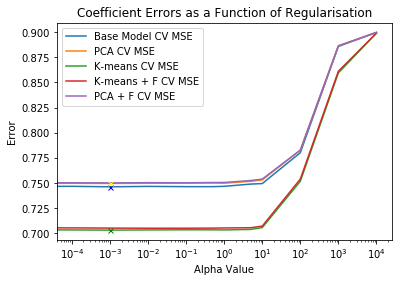

Best Error (Base Model) MSE: 0.7461142197004758
Best Error (PCA) MSE: 0.7494540399925139
Best Error (Kmeans) MSE: 0.7029723332605516
Best Error (Kmeans + F) MSE: 0.7044937382032747
Best Error (PCA + F) MSE: 0.7498980137327883


In [61]:
#Plot the different errors for the optimal parameters in PCA, Kmeans and the combinations, and select the best alpha for each method
km_a_cv_mse = df_km['cv_MSE'].tolist()
pca_a_cv_mse = df_pca['cv_MSE'].tolist()

ax1 = plt.gca()
ax1.plot(alphas,base_a_cv_mse, label = "Base Model CV MSE")
ax1.plot(alphas,pca_a_cv_mse, label = "PCA CV MSE")
ax1.plot(alphas,km_a_cv_mse, label = "K-means CV MSE")
ax1.plot(alphas,km_f_cv_mse, label = "K-means + F CV MSE")
ax1.plot(alphas,pca_f_cv_mse, label = "PCA + F CV MSE")
ax1.plot(alphas[np.argmin(pca_a_cv_mse)], base_a_cv_mse[np.argmin(pca_a_cv_mse)], marker='x', markersize=5, color="blue")
ax1.plot(alphas[np.argmin(pca_a_cv_mse)], pca_a_cv_mse[np.argmin(pca_a_cv_mse)], marker='x', markersize=5, color="yellow")
ax1.plot(alphas[np.argmin(km_a_cv_mse)], km_a_cv_mse[np.argmin(km_a_cv_mse)], marker='x', markersize=5, color="green")
ax1.plot(alphas[np.argmin(km_f_cv_mse)], km_f_cv_mse[np.argmin(km_f_cv_mse)], marker='x', markersize=5, color="red")
ax1.plot(alphas[np.argmin(pca_f_cv_mse)], pca_f_cv_mse[np.argmin(km_f_cv_mse)], marker='x', markersize=5, color="purple")
ax1.legend(loc='best')
ax1.set_xscale('log')
plt.xlabel('Alpha Value')
plt.ylabel('Error')
plt.title('Coefficient Errors as a Function of Regularisation')
plt.show()

print("Best Error (Base Model) MSE: " +str(base_a_cv_mse[np.argmin(base_a_cv_mse)]))
print("Best Error (PCA) MSE: " +str(pca_a_cv_mse[np.argmin(pca_a_cv_mse)]))
print("Best Error (Kmeans) MSE: " +str(km_a_cv_mse[np.argmin(km_a_cv_mse)]))
print("Best Error (Kmeans + F) MSE: " +str(km_f_cv_mse[np.argmin(km_f_cv_mse)]))
print("Best Error (PCA + F) MSE: " +str(pca_f_cv_mse[np.argmin(pca_f_cv_mse)]))


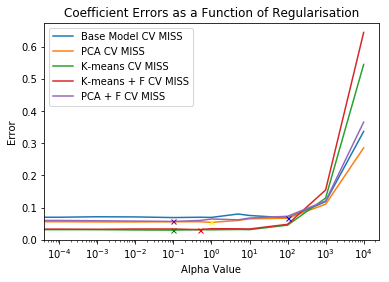

Best Error (Base Model) MISS: 0.06800000000000002
Best Error (PCA) MISS: 0.05400000000000003
Best Error (Kmeans) MISS: 0.030000000000000006
Best Error (Kmeans + F) MISS: 0.031500000000000014
Best Error (PCA + F) MISS: 0.05700000000000001


In [62]:
#Plot the different errors for the optimal parameters in PCA, Kmeans and the combinations, and select the best alpha for each method
km_a_cv_miss = df_km['cv_MISS'].tolist()
pca_a_cv_miss = df_pca['cv_MISS'].tolist()
ax1 = plt.gca()
ax1.plot(alphas,base_a_cv_miss, label = "Base Model CV MISS")
ax1.plot(alphas,pca_a_cv_miss, label = "PCA CV MISS")
ax1.plot(alphas,km_a_cv_miss, label = "K-means CV MISS")
ax1.plot(alphas,km_f_cv_miss, label = "K-means + F CV MISS")
ax1.plot(alphas,pca_f_cv_miss, label = "PCA + F CV MISS")
ax1.plot(alphas[np.argmin(base_a_cv_miss)], base_a_cv_miss[np.argmin(base_a_cv_miss)], marker='x', markersize=5, color="blue")
ax1.plot(alphas[np.argmin(pca_a_cv_miss)], pca_a_cv_miss[np.argmin(pca_a_cv_miss)], marker='x', markersize=5, color="yellow")
ax1.plot(alphas[np.argmin(km_a_cv_miss)], km_a_cv_miss[np.argmin(km_a_cv_miss)], marker='x', markersize=5, color="green")
ax1.plot(alphas[np.argmin(km_f_cv_miss)], km_f_cv_miss[np.argmin(km_f_cv_miss)], marker='x', markersize=5, color="red")
ax1.plot(alphas[np.argmin(pca_f_cv_miss)], pca_f_cv_miss[np.argmin(pca_f_cv_miss)], marker='x', markersize=5, color="purple")
ax1.legend(loc='best')
ax1.set_xscale('log')
plt.xlabel('Alpha Value')
plt.ylabel('Error')
plt.title('Coefficient Errors as a Function of Regularisation')
plt.show()

pca_alpha_opt = alphas[np.argmin(pca_a_cv_miss)]
km_alpha_opt = alphas[np.argmin(km_a_cv_miss)]

print("Best Error (Base Model) MISS: " +str(base_a_cv_miss[np.argmin(base_a_cv_miss)]))
print("Best Error (PCA) MISS: " +str(pca_a_cv_miss[np.argmin(pca_a_cv_miss)]))
print("Best Error (Kmeans) MISS: " +str(km_a_cv_miss[np.argmin(km_a_cv_miss)]))
print("Best Error (Kmeans + F) MISS: " +str(km_f_cv_miss[np.argmin(km_f_cv_miss)]))
print("Best Error (PCA + F) MISS: " +str(pca_f_cv_miss[np.argmin(pca_f_cv_miss)]))

#### Below you can find the single run script that does an end-to-end run of the best model.

In [1]:
# One click run of best model

# Import the libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from random import shuffle
import statistics 


# Set the folder location where the data file is location
file_path = 'DigitsBasicRoutines/'

# Read text file to a data frame
df = pd.read_csv(file_path+'mfeat-pix.txt',sep = " ", header = None)
# Drop empty columns
df = df.dropna(axis=1, how='all').values


# Code to create the teacher vectors. 
# Arguments: Number of classes and Number of observations per class
def create_teacher_vectors(classes, observations):
    teacher_vectors = []
    for i in range(classes):
        for j in range(observations):
            arr = np.zeros((classes,), dtype=int)
            arr[i] = 1
            teacher_vectors.append(arr)
    return teacher_vectors


# Function to generate principal components for the given data.
# Arguments: Dataset and Number of principal components
def PCA(df,pcs):
    # Centre datapoints first
    centred_data = df.T - df.T.mean()  # Transpose and Substract mean
    
    # Create the covariance matrix for our centred datapoints
    covariance_matrix = np.cov(centred_data)
    
    # Eigenvalue / eigen vector decomposition of covariance matrix
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    
    # Create tuples / pairs of corresponding eignevectors with its eigenvalues 
    eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)  # Sort by the eigen values
    
    # Only return the selected number of principal components
    variances = []
    principal_components = []
    for i in range(pcs):
        variances.append(eigen_pairs[i][0])
        principal_components.append(eigen_pairs[i][1])
    
    # Projecting PC into feature vectors, first make list into array type
    W = np.array(principal_components)
    projection_coordinates = W.T
    
    # Project the datapoints onto the PCS, transformed will have the shape d * 1000 where each column is a pattern
    features_pca = W.dot(df.T)
    
    return variances, principal_components, projection_coordinates, features_pca


# Function to generate softmax
# Arguments : Vector and Alpha parameter value
def softmax(v,a):
    return np.exp(a*v) / np.sum(np.exp(a*v), axis=1)


# Create a class to run the regression
class RidgeRigression:
    Wopt = np.zeros(1)  # Solution matrix
    
    # Method to fit the mode, i.e. Generate the solution matrix.
    def fitModel(self, features, output, alpha):
        '''Method to generate the solution matrix based on the provided training features
        and labels.
        Dimentions-
        n-Number of rows, m-Number of features, k-Number of output classes.
        Arguments-
        x_train : nxm Features with rows as individual observations.
        y_train : nxk Outcome matrix.
        Output-
        Sets the Wopt variable of the class to a (m+1)xk solution matrix.
        '''
        X = np.array(features)
        y = np.array(output)
        # Add the bias vector
        ones = np.ones(len(X))
        X = np.column_stack((ones, X))
        # Compute Wopt
        ridge_penalty = (alpha**2)*np.identity(len(X.T))
        pseudo_inverse = np.linalg.pinv(np.dot(X.T, X)+ridge_penalty)
        self.Wopt = np.dot(np.dot(pseudo_inverse, X.T), y)
     
    # Method to predict the outcome based on the solution matrix.
    def pred(self, features, alpha = 1):
        '''Method to generate predictions based on the fitted Wopt.
        Dimentions-
        n-Number of rows, m-Number of features, k-Number of output classes.
        Arguments-
        x_test : nxm Features with rows as individual observations.
        Output-
        Returns the array of predicted target k-dimensional vectors Z
        '''
        if(len(self.Wopt)==0):
            print('Please fit the model before running predict.')
            return
        return (np.dot(features, self.Wopt[1:, ]) + self.Wopt[0, ])
    
    
# Function to return image intensity values
# Arguments : image vector of length 240
def imgIntensities(imgVec):
    shape = (16, 15)
    imat = imgVec.reshape(shape)
    totalIntensity = imat.sum()
    topIntensity = imat[:8, :].sum()
    bottomIntensity = imat[8:, :].sum()
    leftIntensity = imat[:, :7].sum()
    rightIntensity = imat[:, 7:].sum()
    return(totalIntensity, topIntensity, bottomIntensity,
           leftIntensity, rightIntensity)


# Function to assign each data point to a random cluster
# Arguments :
# df : the two dimnestional data array of image vectors
# k : number of clusters to which the data should be assigned
def random_assign_class(df, k):
    # Ensure that all classes are initialised at least once
    x = [x for x in range(k)]
    shuffle(x)
    # Fill in the other points that havent been initialised randomly
    missing_index = len(df) - len(x)
    missing_values = np.random.randint(0, k, missing_index)
    # join the two random initialisations together
    final_initialisation = x + missing_values.tolist()
    groups = np.zeros((len(final_initialisation), 1))
    for indx, item in enumerate(final_initialisation):
        groups[indx] = item
    data = np.append(df, groups, axis=1)
    return data


# Function to run K-Means clustering, takes two arguments
# data : ndarray of data points that need to be clustered
# clusterSize : number of clusters
def kmeans(data, clusterSize):
    numData = len(data)         # Number of data points
    dimSize = len(data[0])      # Dimension of each data point
    # Assign each point to a cluster randomly
    data = random_assign_class(data, clusterSize)

    # Keep running the kmeans algorithm while the classes keep changing
    classChange = True
    while classChange == True:
        # Store the old class values for all the image vectors
        oldClasses = data[:, -1].copy()
        # Calculate the centroid for each group and store it in a numpy array
        # the centroid is just an average of all the points in the group
        centroid = np.zeros((clusterSize, dimSize))
        for i in range(len(centroid)):
            if (len(data[data[:, -1] == i]))!= 0 :
                centroid[i] = np.sum(data[data[:, -1] == i][:, :-1], axis=0)/len(data[data[:, -1] == i])
            else :
                np.delete(centroid,centroid[i],axis = 0)

        # Calculate the distance of each point from all the centroids
        distances = np.zeros((numData, clusterSize))
        for i in range(len(distances)):
            for j in range(len(distances[i])):
                distances[i, j] = np.linalg.norm(data[i, :-1]-centroid[j])
        # Re-assign the groups based on closest centroid
        for i in range(len(distances)):
            data[i, -1] = np.argmin(distances[i])
        # Store the new class values for the image vector
        newClasses = data[:, -1].copy()

        # Compare if the old and new classes are the same
        if sum(newClasses != oldClasses) == 0:
            classChange = False

    return centroid


# Function to generate the Mean Squared Error value 
# Arguments : Vector of Predicted values and Vector of Actual values
def MSE(pred,actual):
    v = pred-actual
    squared_error = []
    for i in range(len(v)):
        err = (np.linalg.norm(v[i]))**2
        squared_error.append(err)
    return statistics.mean(squared_error)


# Function to generate the Misclassification Error value 
# Arguments : Vector of Predicted values and Vector of Actual values
def misclassification_rate(pred,actual):
    return 1-((sum(np.array([np.argmax(a) for a in pred])==np.array([np.argmax(a) for a in actual]))).astype("float")/len(actual))


# Function that merges train test set together for CV dataset
# Arguments:
# Train_X : Array of training feature vectors
# Train_Y : Array of training output vectors
# Test_X : Array of test feature vectors
# Test_Y : Array of test output vectors
def create_full_dataset(train_X,train_y,test_X,test_y):
    data = np.concatenate((train_X,test_X))
    labels = np.concatenate((train_y,test_y)).tolist()

    df_full = pd.DataFrame(data)
    df_full['label'] = labels
    dataset = df_full.values
    
    return dataset


# Function to cross validate a model using k-fold cross validation and generate CV error rates
# Arguments :
# Dataset: The complete dataset which will be used for cross validation
# k : Number of folds to be used for cross validation
# model : Ridge regression class object that will be used for cross validation
# alpha : Parameter value for the ridge
def kfold_cv(dataset,k,model,alpha):
    size = int(len(dataset)/k)
    #shuffle array
    np.random.shuffle(dataset)
    
    cv_miss = []
    cv_mse = []
    for i in range(k):
    
        #create train and test indices
        test_indices = range(i*size,size+(i*size))
        train_indices = range(0,len(dataset))
        #remove the test indices from the train set
        train_indices = [x for x in train_indices if x not in test_indices]
    
        #split train test sets
        test_arr = dataset[test_indices]
        train_arr = dataset[train_indices]
    
        #split the features and the response
        tr_x = train_arr[:,:-10]
        te_x = test_arr[:,:-10]
        tr_y = train_arr[:,-10:]
        te_y = test_arr[:,-10:]
        #fit model
        clf = model
        clf.fitModel(tr_x,tr_y,alpha)
        ypred = clf.pred(te_x)
        
        #compute misclassification rate
        cv_miss.append(1-((sum(np.array([np.argmax(a) for a in ypred])==np.array([np.argmax(a) for a in te_y]))).astype("float")/size))
        
        #compute MSE
        cv_mse.append(MSE(ypred,te_y))
        
    return statistics.mean(cv_miss), statistics.mean(cv_mse)


# Take the feature data and find the codebook vectors using k=90
X = np.copy(df[:, :])
cbs = kmeans(X, 90)

# Calculate distances of all the features from the codebook vectors
distX = np.array([np.linalg.norm(X-b,axis=1) for b in cbs])

# Get the output list
Y = create_teacher_vectors(10,200)

# Generate combined dataset with features and outcome
ds = np.append(distX.T,Y,axis=1)

# Initialize the classifier obejct
clf = RidgeRigression()

# Run the cross validation with 10 folds and alpha set as 5
cvMis, cvMSE = kfold_cv(ds, 10, clf, 5)

print("Average Misclassification rate:"+str(cvMis))
print("Average Mean Squared Error rate:"+str(cvMSE))

/home/prateek/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Average Misclassification rate:0.030500000000000027
Average Mean Squared Error rate:0.14723549612127448
